In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
image_transforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [4]:
dataset_path="./dataset"
dataset=datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

2300

In [5]:
train_size=int(0.75*len(dataset))
val_size=len(dataset)-train_size    
train_size,val_size

(1725, 575)

In [11]:
num_classes=len(dataset.classes)
num_classes

6

In [6]:
from torch.utils.data import random_split   

train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

In [7]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)

In [8]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.7685405].


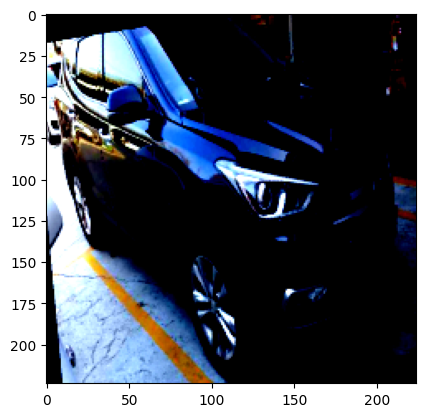

In [9]:
plt.imshow(images[0].permute(1,2,0))

### Model Training and hyperparameter tuning

In [10]:
class CarClassiferResNet(nn.Module):
    def __init__(self,num_classes,dropout_rate=0.5):
        super().__init__()
        self.model=models.resnet50(weights='DEFAULT')
        ##Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False ##freezing the layers

        ##Unfreeze layer 4 and fc layers=>learns from our training data
        for param in self.model.layer4.parameters():
            param.requires_grad = True    
        
        ##Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [12]:
import optuna

In [13]:
#Define the objective function for optuna

def objective(trial):
    #Suggest values for hyperparameters
    lr=trial.suggest_float("lr",1e-5,1e-1,log=True)
    dropout_rate=trial.suggest_float("dropout_rate",0.2,0.7)

    #load the model
    model=CarClassiferResNet(num_classes=num_classes,dropout_rate=dropout_rate).to(device)


    #Define the loss function and optimizer
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    #Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs=3
    start=time.time()
    for epoch in range(epochs):
        model.train()
        running_loss=0
        for batch_num,(images,labels) in enumerate(train_loader):
            images,labels=images.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()*images.size(0)
        
        epoch_loss=running_loss/len(train_loader.dataset)


        #validation loop
        model.eval()
        correct=0
        total=0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels=images.to(device),labels.to(device)
                outputs=model(images)
                _,predicted=torch.max(outputs,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
        accuracy=100*correct/total

        #Report the intermediate result to optuna
        trial.report(accuracy, epoch)

        ##Handle pruning if applicable
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    end=time.time()
    print(f"Execution time: {end-start:.2f} seconds")
    return accuracy

In [ ]:
#Create the study and optimize
study=optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=20)

[I 2025-08-23 10:21:30,406] A new study created in memory with name: no-name-f4761647-20ee-467d-8e8b-93a52166079e
[I 2025-08-23 10:51:19,608] Trial 0 finished with value: 70.26086956521739 and parameters: {'lr': 5.0655497271689926e-05, 'dropout_rate': 0.6668690694865287}. Best is trial 0 with value: 70.26086956521739.


Execution time: 1788.16 seconds


[I 2025-08-23 11:19:47,616] Trial 1 finished with value: 66.78260869565217 and parameters: {'lr': 0.09086914584459002, 'dropout_rate': 0.556554531887583}. Best is trial 0 with value: 70.26086956521739.


Execution time: 1707.25 seconds


[I 2025-08-23 11:55:51,571] Trial 2 finished with value: 76.34782608695652 and parameters: {'lr': 8.51404447712198e-05, 'dropout_rate': 0.6822602686208816}. Best is trial 2 with value: 76.34782608695652.


Execution time: 2163.52 seconds


[I 2025-08-23 14:25:28,330] Trial 3 finished with value: 79.30434782608695 and parameters: {'lr': 0.0003911671758118242, 'dropout_rate': 0.25160298606223197}. Best is trial 3 with value: 79.30434782608695.


Execution time: 8975.83 seconds


[I 2025-08-23 14:51:54,772] Trial 4 finished with value: 57.04347826086956 and parameters: {'lr': 2.0614405200639538e-05, 'dropout_rate': 0.5505674209355742}. Best is trial 3 with value: 79.30434782608695.


Execution time: 1585.70 seconds


[I 2025-08-23 15:01:19,190] Trial 5 pruned. 
[I 2025-08-23 15:37:04,861] Trial 6 finished with value: 80.52173913043478 and parameters: {'lr': 0.0008139062480621323, 'dropout_rate': 0.6634221150913229}. Best is trial 6 with value: 80.52173913043478.


Execution time: 2145.05 seconds


[I 2025-08-23 15:43:12,607] Trial 7 pruned. 
[I 2025-08-23 16:01:00,804] Trial 8 finished with value: 77.3913043478261 and parameters: {'lr': 6.443377852989867e-05, 'dropout_rate': 0.22329332921349954}. Best is trial 6 with value: 80.52173913043478.


Execution time: 1067.42 seconds


[I 2025-08-23 19:52:02,055] Trial 9 finished with value: 79.1304347826087 and parameters: {'lr': 0.0005334178111503729, 'dropout_rate': 0.40684611664316106}. Best is trial 6 with value: 80.52173913043478.


Execution time: 13860.39 seconds


In [ ]:
study.best_params